In [0]:
%cd "/content/drive/My Drive/Uni Stuff/DSinLS/Task7"

/content/drive/My Drive/Uni Stuff/DSinLS/Task7


In [0]:
%matplotlib inline

import glob
from platform import python_version

import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

plt.rcParams[
    "figure.facecolor"
] = "w"

In [0]:
def generate_sequence(scaler, model, x_sample, future=100):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df
    

**Real Dataset - Confirmed Cases in Germany**

1.Data preprocessing

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


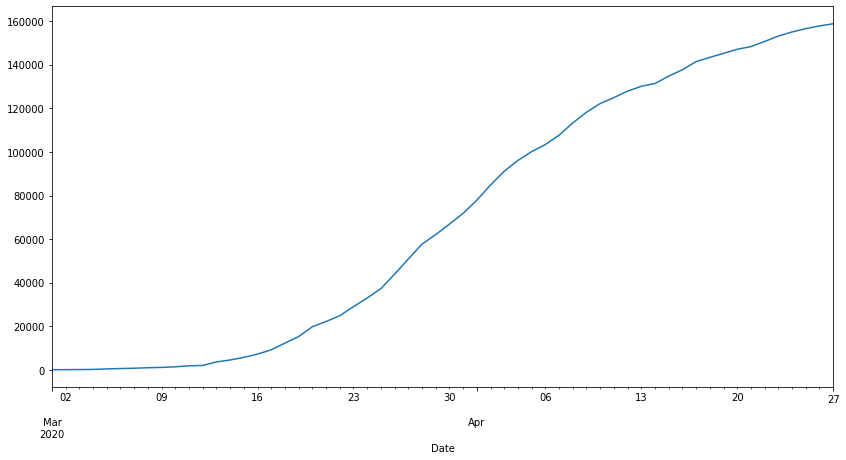

In [0]:
dateCols = ['Date']
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
df = pd.read_csv('./Data/time_series_covid19_confirmed_global.csv',delimiter=';', parse_dates=dateCols,date_parser=mydateparser)
start_date = '2020-02-29'
end_date = '2020-04-27'
mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
df = df.loc[mask]
df.set_index('Date')


df_grouped=df.set_index('Date').groupby(pd.Grouper(freq='1Min') ,  group_keys=False ).apply(
    lambda row: row.confirmed_cases
)

ax=df_grouped.plot(figsize=(14, 7))

In [0]:
df_train = df_grouped[df_grouped.index < "2020-04-20"].to_frame(name="confirmed_cases")
df_val = df_grouped[df_grouped.index >= "2020-04-20"].to_frame(name="confirmed_cases")
#df_test = df_grouped[df_grouped.index >= "2020-04-10"].to_frame(name='confirmed_cases')

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
#test_arr = scaler.transform(df_test)

In [0]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

from torch.autograd import Variable

seq_len = 2

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
#x_test, y_test = transform_data(test_arr, seq_len)

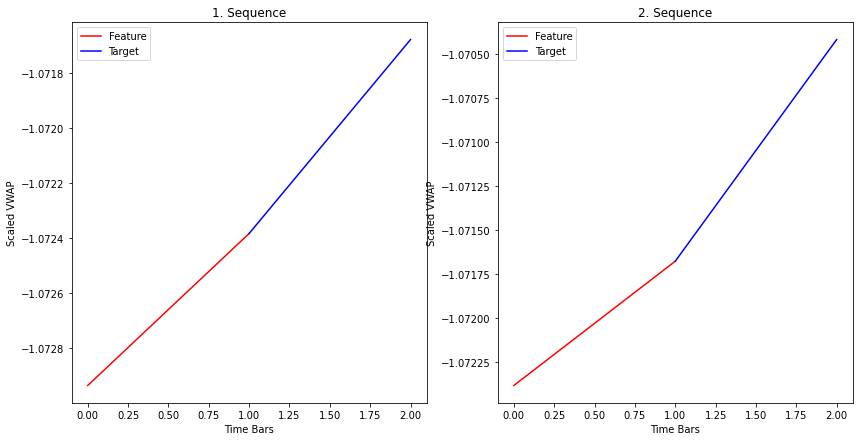

In [0]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [0]:
from LSTM import *
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-2)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [0]:
optimization_1.train(x_train, y_train, x_val, y_val,batch_size=1,n_epochs=25, do_teacher_forcing=True)


Epoch 1 Train loss: 0.68. Validation loss: 0.80. Avg future: 1.00. Elapsed time: 0.35s.
Epoch 2 Train loss: 0.46. Validation loss: 0.46. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 3 Train loss: 0.06. Validation loss: 0.18. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 4 Train loss: 0.11. Validation loss: 0.02. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 5 Train loss: 0.09. Validation loss: 0.03. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 6 Train loss: 0.07. Validation loss: 0.03. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 7 Train loss: 0.05. Validation loss: 0.01. Avg future: 1.00. Elapsed time: 0.08s.
Epoch 8 Train loss: 0.03. Validation loss: 0.00. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 9 Train loss: 0.03. Validation loss: 0.00. Avg future: 1.00. Elapsed time: 0.08s.
Epoch 10 Train loss: 0.03. Validation loss: 0.00. Avg future: 1.00. Elapsed time: 0.08s.
Epoch 11 Train loss: 0.02. Validation loss: 0.00. Avg future: 1.00. Elapsed time: 0.07s.
Epoch 12 Train loss: 0.02. Val

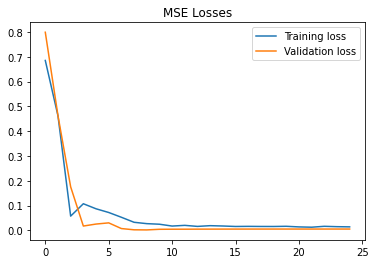

In [0]:
optimization_1.plot_losses()

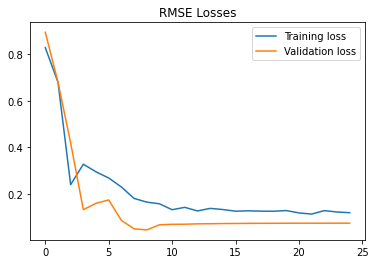

In [0]:
optimization_1.plot_RMSElosses()

Test loss 0.0081


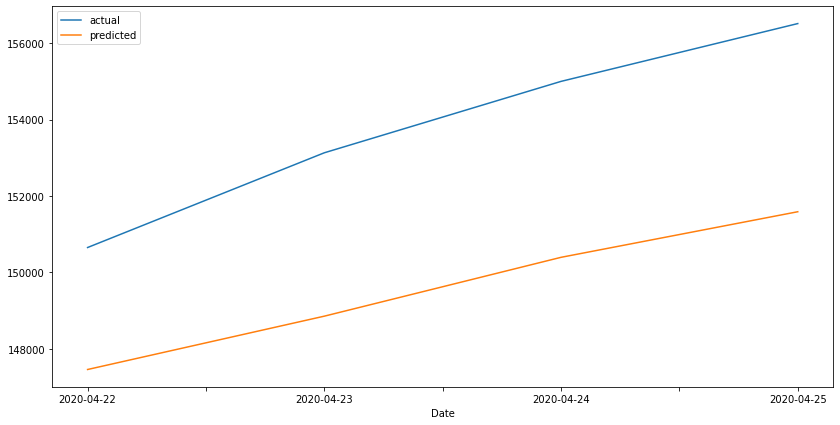

In [0]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_val, y_val, future=0, batch_size=2)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1=df_result_1.assign(Date = ["2020-04-22","2020-04-23", "2020-04-24", "2020-04-25"])
ax=df_result_1.plot(figsize=(14, 7),x="Date")
print("Test loss %.4f" % test_loss_1)

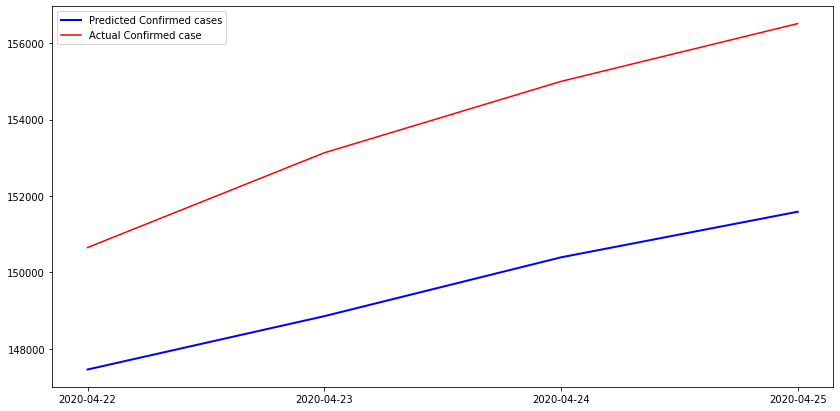

In [0]:
plt.figure(figsize=(14, 7))

plt.plot(df_result_1.Date, df_result_1.predicted, color="blue", lw=2, label="Predicted Confirmed cases")
plt.plot(df_result_1.Date, df_result_1.actual, color="red", label="Actual Confirmed case")
plt.legend()
